In [11]:

import os
from glob import glob
import re
import logging
from tqdm import tqdm
from itertools import chain

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


import torch
from torch.utils.data import Dataset,DataLoader,random_split
import torchvision.transforms as transforms
from PIL import Image
import albumentations as A

from models import encoders, decoders
from src import datasets, utils, metrics


from torch import nn
from torch.nn import functional as F

In [2]:
import os
import logging
import numpy as np
import pandas as pd
import joblib
import random
from torchvision import transforms
from natsort import natsorted
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split

In [6]:

"""
This function loads the data for Eurosat
"""
def _load_eurosat_data(normalization, evaluate, data_size=None, augmentations=False):
    
    if normalization == "dataTwelve":
        # 12-channel files 
        data_path = "/scratch/mh613/NewEuroSat/"
    else:
        # rgb files
        data_path = "/scratch/yc506/NewEuroSat_rgb/"
    # a list of files in the data path 
    file_set = os.listdir(data_path)
    
    # train val test split 
    old_train_files, rem = train_test_split(file_set, test_size=0.2, random_state = 123)
    # 11736 is the number of training file we will have 0.8 *14k 
    if data_size!= 11736: 
        train_files = random.sample(old_train_files, data_size)
    else: 
        train_files = old_train_files
    test_files, val_files = train_test_split(rem, test_size=0.5, random_state = 123)
    
    if normalization != "dataTwelve":
        # mean and std for RGB data
        normalize = {"mean": [44.04389265, 49.10599284, 31.27095929], "std": [41.61620523, 38.21741166, 31.96225992]}
    elif normalization == "dataTwelve":
            ################ to be changed for eurosat 12-channel values #############
            normalize = {
            "mean": [
                616.95329649,
                867.83717358,
                842.86595966,
                1285.77942965,
                2308.69512439,
                2650.97561424,
                2791.82155065,
                2832.1399957,
                1967.90223554,
                1343.787036,
                -11.92402614,
                -18.43180948,
            ],
            "std": [
                850.36421999,
                837.83275801,
                931.51194456,
                920.84945907,
                1222.92903347,
                1426.90538092,
                1514.24879853,
                1491.36178338,
                1063.20240616,
                917.98727869,
                5.22952371,
                5.06522831,
            ],
        }
            ################ to be changed for eurosat 12-channel values #############
    tr_normalize = transforms.Normalize(mean=normalize["mean"], std=normalize["std"])
    train_transform = transforms.Compose([transforms.ToTensor(), tr_normalize])
    test_transform = transforms.Compose([transforms.ToTensor(), tr_normalize])
    if augmentations:
        print("Adding augmentations...")
        aug = A.Compose(
            [
                A.RandomRotate90(),
                A.VerticalFlip(),
                A.HorizontalFlip(),
                A.Transpose(),
                A.Normalize(mean=normalize["mean"], std=normalize["std"]),
                ToTensorV2(),
            ]
        )

    logging.debug("Creating the training dataset.")
    if augmentations:
        train_dataset = Eurosat(
            data_path,
            train_files,
            transform=train_transform,
            augmentations=aug,
        )
    else:
        if normalization == "dataTwelve":
            train_dataset = Eurosat12(
                data_path, train_files, transform=train_transform
            )
        else:
            train_dataset = Eurosat(
                data_path, train_files, transform=train_transform
            )


    logging.debug("Creating the test dataset.")
    if normalization == "dataTwelve":
        val_dataset = Eurosat12(
            data_path, val_files, transform=test_transform
        )
        test_dataset = Eurosat12(
            data_path, test_files, transform=test_transform
        )
    else:
        val_dataset = Eurosat(
            data_path, val_files, transform=test_transform
        )
        # Return the training and test dataset
        test_dataset = Eurosat(
            data_path, test_files, transform=test_transform
        )

    #train_dataset = Eurosat(data_path, train_files, transform=train_transform)
    #val_dataset = Eurosat(data_path, val_files, transform=test_transform)



    # Return the training and test dataset
 #  test_dataset = Eurosat(data_path, test_files, transform=test_transform)
    if evaluate:
        return test_dataset

    return train_dataset, val_dataset

In [3]:
train_data,test_data= datasets._load_eurosat_data(
       normalization="dataTwelve",augmentations=False ,size=500,evaluate=False
    )

False


In [3]:
train_data, test_data = _load_eurosat_data(
    normalization="dataTwelve",
    augmentations=False,
    data_size=20,
    evaluate=False,
)
# train_data, test_data = _load_eurosat_data(
#     normalization="data",
#     augmentations=False,
#     data_size=20,
#     evaluate=False,
# )

NameError: name '_load_eurosat_data' is not defined

In [4]:
train_loader = DataLoader(
    train_data, batch_size=20, shuffle=True)
test_loader = DataLoader(
    test_data, batch_size=20, shuffle=False)

In [18]:
# Define the path to your image folder and file names after train/test split
from src.tasks.eurosat_swav12 import Eurosat12

normalize = {
                "mean": [
                    0.04560511,
                    0.07832425,
                    0.07050303,
                    0.13134229,
                    0.29649284,
                    0.35478109,
                    0.37182458,
                    0.38193435,
                    0.22069953,
                    0.13402856,
                    -12.5696884,
                    -18.2610512,
                ],
                "std": [
                    0.06170507,
                    0.06207748,
                    0.07390513,
                    0.06927535,
                    0.0757848,
                    0.09344653,
                    0.09964956,
                    0.09542389,
                    0.07652418,
                    0.0762175,
                    4.31484634,
                    3.4123834,
                ],
            }
            ################ to be changed for eurosat 12-channel values #############


tr_normalize = transforms.Normalize(mean=normalize["mean"], std=normalize["std"])
train_transform = transforms.Compose([ tr_normalize])
path = "/scratch/mh613/NewEuroSat/"
train_files = ["SeaLake_99.tif", "SeaLake_99.tif"]



# Create the train and test datasets using Eurosat12 class
train_data = Eurosat12(path, train_files, transform=train_transform)
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
for batch_idx, (data, target) in enumerate(train_loader):
    
    assert data.shape[0] == 1, f"Batch {batch_idx} has size {data.shape[0]}, expected {batch_size}"

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


In [9]:
from torch import nn
from torch.nn import functional as F

####### Linear evaluation class ############
####### reference : SwAV github 
class RegLog(nn.Module):
    """Creates logistic regression on top of frozen features"""

    def __init__(self, num_labels, global_avg=False, use_bn=True):
        super(RegLog, self).__init__()
        self.bn = None
        if global_avg:
            s = 2048
            self.av_pool = nn.AdaptiveAvgPool2d((1, 1))
        else:
            s = 8192
            self.av_pool = nn.AvgPool2d(6, stride=1)
            if use_bn:
                self.bn = nn.BatchNorm2d(2048)
        self.linear = nn.Linear(s, num_labels)
        self.linear.weight.data.normal_(mean=0.0, std=0.01)
        self.linear.bias.data.zero_()

    def forward(self, x):
        # average pool the final feature map
        x = self.av_pool(x)

        # optional BN
        if self.bn is not None:
            x = self.bn(x)

        # flatten
        x = x.view(x.size(0), -1)

        # linear layer
        return self.linear(x)

In [6]:
encoder = encoders.load("swav-12")
#encoder=encoders.load("swav-b3")
decoder = RegLog(10)


Loading 12 channel swav pretrained weights.


In [18]:
global DEVICE
import torch
def set_device(d):
    if d == "auto":
        device = "cuda" if torch.cuda.is_available() else "cpu"
    else:
        device = d
    return device

DEVICE = set_device("auto")
#DEVICE = set_device('cpu')
print("Device is " + DEVICE)
encoder = encoder.to(DEVICE)
decoder = decoder.to(DEVICE)

params = decoder.parameters()

Device is cuda


NameError: name 'encoder' is not defined

In [10]:
def save_model(enc, dec, dump_path, name):
    torch.save(enc.state_dict(), os.path.join(dump_path, "enc_" + name))
    torch.save(dec.state_dict(), os.path.join(dump_path, "dec_" + name))

def train(loader, encoder, decoder, optimizer, criterion, fine_tune_encoder = False):

    if fine_tune_encoder:
        encoder.train()
    else:
        encoder.eval()

    decoder.train()
    criterion = criterion.to(DEVICE)
    avg_loss = utils.AverageMeter()
    num_batches = len(loader)
    for batch_idx, (inp, target) in enumerate(loader):
        if batch_idx % 10 == 0:
            print(f"Beginning batch {batch_idx} of {num_batches}")
        logging.debug(f"Training batch {batch_idx}...")
        # Move to the GPU
        inp = inp.to(DEVICE)
        target = target.to(DEVICE)

        if fine_tune_encoder:
            output = encoder(inp)
        else:
            with torch.no_grad():
                output = encoder(inp)
        ################### The change I'm not super sure #####################
        output = decoder(output[0])
        ########################################################################
        loss = criterion(output, target)

        if batch_idx % 10 == 0:
            print(f"\t Train Loss: {loss.item()}")
        # Calculate the gradients
        optimizer.zero_grad()
        loss.backward()
        avg_loss.update(loss.item(), inp.size(0))
        # Step forward
        optimizer.step()

    return avg_loss.avg

In [11]:

@torch.no_grad()
def test(data_loader, encoder, decoder, criterion):

    encoder.eval()
    decoder.eval()
    criterion = criterion.to(DEVICE)
    avg_loss = utils.AverageMeter()
    for batch_idx, (inp, target) in enumerate(data_loader):
        # Move to the GPU
        if batch_idx % 100 == 0:
            print(f"Testing batch {batch_idx}")
        inp = inp.to(DEVICE)
        target = target.to(DEVICE)

        # Compute output
        
        ################### The change I'm not super sure #####################
        output = encoder(inp)
        output = decoder(output[0])
        ########################################################################
        loss = criterion(output, target)
        avg_loss.update(loss.item(), inp.size(0))
        if batch_idx % 10 == 0:
            print(f"\t Test Loss: {loss.item()}")

    return avg_loss.avg

In [13]:
# probably needs to change
optimizer = torch.optim.Adam(
    decoder.parameters(), lr=1e-3, weight_decay=0)

In [ ]:
criterion =  nn.CrossEntropyLoss().to(DEVICE)
monitor_pth = "../df"#"/home/yc506/ssrs/experiments/results/eurosat_resize_swav"

epoch_timer = utils.Timer()
monitor = utils.PerformanceMonitor(monitor_pth)
best_test_loss = float("inf")
# do 100 epochs
for epoch in range(100):
    print(f"Beginning epoch {epoch}")
    logging.info(f"Beginning epoch {epoch}...")

    loss = train(train_loader, encoder, decoder, optimizer, criterion)
    monitor.log(epoch, "train", loss)

    loss = test(test_loader, encoder, decoder, criterion)
    monitor.log(epoch, "val", loss)
    logging.info(
        f"Epoch {epoch} took {epoch_timer.minutes_elapsed()} minutes.")
    epoch_timer.reset()

    if loss < best_test_loss:
        logging.info("Saving model")
        save_model(encoder, decoder, monitor_pth, "best.pt")
        best_test_loss = loss
save_model(encoder, decoder, monitor_pth, "final.pt")

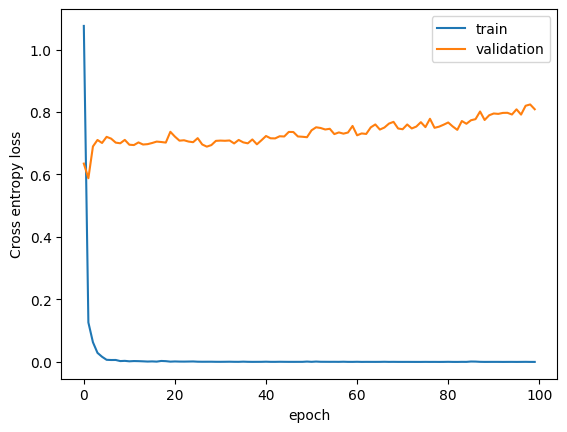

In [6]:
train_progress = pd.read_csv(os.path.join("../df","performance.csv"))
fig,ax = plt.subplots()
ax.plot(train_progress.epoch[train_progress["stage"]=="train"],train_progress.loss[train_progress["stage"]=="train"],label="train")
ax.plot(train_progress.epoch[train_progress["stage"]=="val"],train_progress.loss[train_progress["stage"]=="val"],label="validation")
ax.set_xlabel("epoch")
ax.set_ylabel("Cross entropy loss")
ax.legend()
plt.show()

In [33]:
bestOrFinal = "final"
weights_folder = "../dr/500/Eurosat_12/1"#"results/field_delineation_10ep/" #
encoderWeights_path = os.path.join(weights_folder,f"enc_{bestOrFinal}.pt")
decoderWeights_path = os.path.join(weights_folder,f"dec_{bestOrFinal}.pt")

# EVALUATE

In [39]:
test_data= datasets._load_eurosat_data(
       normalization="data",augmentations=False ,size=500,evaluate=True
    )
test_loader = DataLoader(
    test_data, batch_size=20, shuffle=False)

False


In [40]:
encoder_trained =encoder = encoders.load("swav-b3")
decoder_trained = RegLog(10)
decoder_trained.load_state_dict(torch.load(decoderWeights_path))
encoder_trained = encoder_trained.eval()
decoder_trained = decoder_trained.eval()

Loading swav-b3.


In [41]:
dataloader = test_loader
encoder = encoder_trained.to(DEVICE)
decoder = decoder_trained.to(DEVICE)


In [42]:
def get_prediction_accuracy(dataloader, encoder, decoder):
    #preds = []
    #targets = []
    correct = 0
    total = 0
    for i, (img, label) in enumerate(dataloader):
        # Load through the model.
        img = img.to(DEVICE)
        label = label.to(DEVICE)
        with torch.no_grad():
            output = encoder(img)
            output = decoder(output[0])
            pred_prob = torch.sigmoid(output) #activation function sigmoid function
            _, predicted = torch.max(pred_prob, 1) # the maximum probability class will be picked as our prediction 
            total += label.size(0) # the total number of prediction 
            correct += (predicted == label).sum().item() 
    return correct/total 

In [43]:
get_prediction_accuracy(test_loader, encoder, decoder)

0.09815950920245399